<a href="https://colab.research.google.com/github/LuisOlCo/Semantic-Search/blob/main/sentence_transformers_cuda_v2_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MOUNT DRIVE

In [ ]:
from google.colab import drive
import sys

In [ ]:
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/Semantic_Search')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Execute

In [ ]:
!pip install transformers
!pip install scipy
!pip install sentence_transformers

In [ ]:
import pandas as pd
import torch
import scipy.spatial

from transformers import AutoTokenizer, AutoModel

from dataset import *
from heapmod import *
from utils import *
from vocabulary import *

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")

True
Tesla T4


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
model.eval()
model.to(device)

SentenceTransformer(
  (0): Transformer(
    (auto_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
       

EXPLORING DATABASE

In [ ]:
key_path = 'XXXXXXXXXXXXXXXXXXXXXXXXXXX'
tweet_table = 'YYYYYYYYYYYYYYYYYY'
reddit_table = 'YYYYYYYYYYYYYYYYYY'
datasetSQL = DatasetSQL.connect_to_DB_GCP(key_path)

query_sql = """
   SELECT tweet_id, tweet
   FROM YYYYYYYYYYYYYYYYYY
   LIMIT 100000"""

result = datasetSQL.get_result_query(query_sql)
results_df = result.to_dataframe()

In [ ]:
data_loader = torch.utils.data.DataLoader(DatasetPandas2Torch(results_df), batch_size=128)

In [ ]:
import time
start_time = time.time()
query = 'Coronavirus strikes European economies, what are the countries that are suffering the most during this pandemic?'
score_rank = Heap()

for batch_idx, sample in enumerate(data_loader):
  print('Batch idx: ',batch_idx)
  print('Tweet: ',sample[0])
  print('Tweet_id: ',sample[1])

  tweets = sample[0]
  tweets_id = sample[1]

  # Clean cuda allocated memory
  torch.cuda.empty_cache()


  # Model output embeddings
  with torch.no_grad():
    sentence_embeddings = model.encode(tweets)

 # Model output embeddings
  with torch.no_grad():
    query_embeddings = model.encode([query])

  # COMPUTE THE SCORES BETWEEN TWEETS AND THE QUERY
  # Compute distances
  distances = scipy.spatial.distance.cdist(query_embeddings, sentence_embeddings, "cosine")[0]
  results = zip(-1*distances,tweets_id,sentence_embeddings)
  results = sorted(results, key = lambda x: x[0])

  # Need to add the results to the heap
  for tweet_score in results:
    score = tweet_score[0]
    tweet = tweet_score[1]
    embedding = tweet_score[2]
    score_rank.insert(score,tweet,embedding)

print('Total time: ', time.time() - start_time)
  

Streaming output truncated to the last 5000 lines.
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lower than min
Items score is lowe

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)

In [ ]:
clustering_model.fit([i.tweet_embedding for i in score_rank.heap])
cluster_assignment = clustering_model.labels_

In [ ]:
# Group tweet ids by cluster
cluster_tweet_id = {}
for k,element in zip(cluster_assignment, score_rank.heap):
  if k in cluster_tweet_id:
    cluster_tweet_id[k].append(element.tweet_id)
  else:
    cluster_tweet_id[k] = [element.tweet_id]

In [ ]:
data_clusters = pd.DataFrame(columns = ['cluster','tweet','tweet_id'])

In [ ]:
for k in cluster_tweet_id:
  for tweet_idx in cluster_tweet_id[k]:
    data_clusters = data_clusters.append({'cluster':k,'tweet':results_df.loc[results_df['tweet_id'] == tweet_idx, 'tweet'].values[0], 'tweet_id':tweet_idx},ignore_index=True)

In [ ]:
data_clusters.head()

,cluster,tweet,tweet_id
0,4,The Infection That’s Silently Killing Coronavi...,1252705388232925186
1,4,CNN Photo Editor Mohammed Elshamy Posted Anti-...,1154551448006516736
2,4,The greatest real life plot twist in history. ...,405749210026213377
3,4,ICYMI: Ping CCIO Richard Bird joins the @DtSR_...,1082331462819442688
4,4,"@the_superhero Totally, that's what we said . ...",24948482077


In [ ]:
data = clean_selected_tweets(data_clusters)

In [ ]:
data.head()

,cluster,tweet,tweet_id,Tokenize
0,4,the infection that’s silently killing coronavi...,1252705388232925186,"[infection, silently, kill, coronavirus, patie..."
1,4,cnn photo editor mohammed elshamy posted antis...,1154551448006516736,"[cnn, photo, editor, mohammed, elshamy, post, ..."
2,4,the greatest real life plot twist in history i...,405749210026213377,"[great, real, life, plot, twist, history, invo..."
3,4,icymi ping ccio richard bird joins the dtsrpod...,1082331462819442688,"[icymi, ping, ccio, richard, bird, join, dtsrp..."
4,4,thesuperhero totally thats what we said jay z ...,24948482077,"[thesuperhero, totally, s, say, jay, z, ruin, ..."


In [ ]:
vocab = Vocabulary()
for cluster in data['cluster'].unique():
    mask = data['cluster'] == cluster
    data_cluster = data[mask]
    data_cluster['Tokenize'].apply(lambda sentence: [vocab.update_vocabulary(token,cluster) for token in sentence])

In [ ]:
from gensim import corpora, models

In [ ]:
token_to_idx = vocab.token_to_idx
idx_to_token = vocab.idx_to_token
cluster_counter = vocab.chapter_counter

In [ ]:
bow_corpus = get_bow_corpus(token_to_idx,cluster_counter)

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
top_n_relevant_words = 10
#chapter = 3
#relevant_words_TDIDF_per_chapter(top_n_relevant_words,corpus_tfidf[chapter],idx_to_token)

for i in range(9):
    print('MOST RELEVANT WORDS IN CHAPTER {} ARE: \n{}' .format(i+1,relevant_words_TDIDF_per_cluster(top_n_relevant_words,corpus_tfidf[i],idx_to_token)))
    print('\n')

MOST RELEVANT WORDS IN CHAPTER 1 ARE: 
['dc', '😂', None, 'blow', 'destroy', None, 'destruction', '❤', None, 'devastate']


MOST RELEVANT WORDS IN CHAPTER 2 ARE: 
['isolation', None, None, 'address', None, 'shut', None, 'not', 'deliver', 'delay']


MOST RELEVANT WORDS IN CHAPTER 3 ARE: 
['classof', None, None, 'infection', None, None, None, 'update', 'pandemic', 'novel']


MOST RELEVANT WORDS IN CHAPTER 4 ARE: 
['raid', None, 'tory', 'undermine', None, 'd', 'lie', 'russian', None, 'fbi']


MOST RELEVANT WORDS IN CHAPTER 5 ARE: 
['theft', 'ai', None, 'cybersecurity', 'retailer', None, 'webinar', None, 'cyber', 'hacker']


MOST RELEVANT WORDS IN CHAPTER 6 ARE: 
['spiral', None, None, None, None, None, None, 'difficult', 'german', None]


MOST RELEVANT WORDS IN CHAPTER 7 ARE: 
['sure', 'death', 'endangered', None, None, None, None, '😂', 'cancer', 'chemical']


MOST RELEVANT WORDS IN CHAPTER 8 ARE: 
['retailer', 'billion', 'currency', None, 'asset', None, None, 'bitcoin', 'bank', '·']


MOS

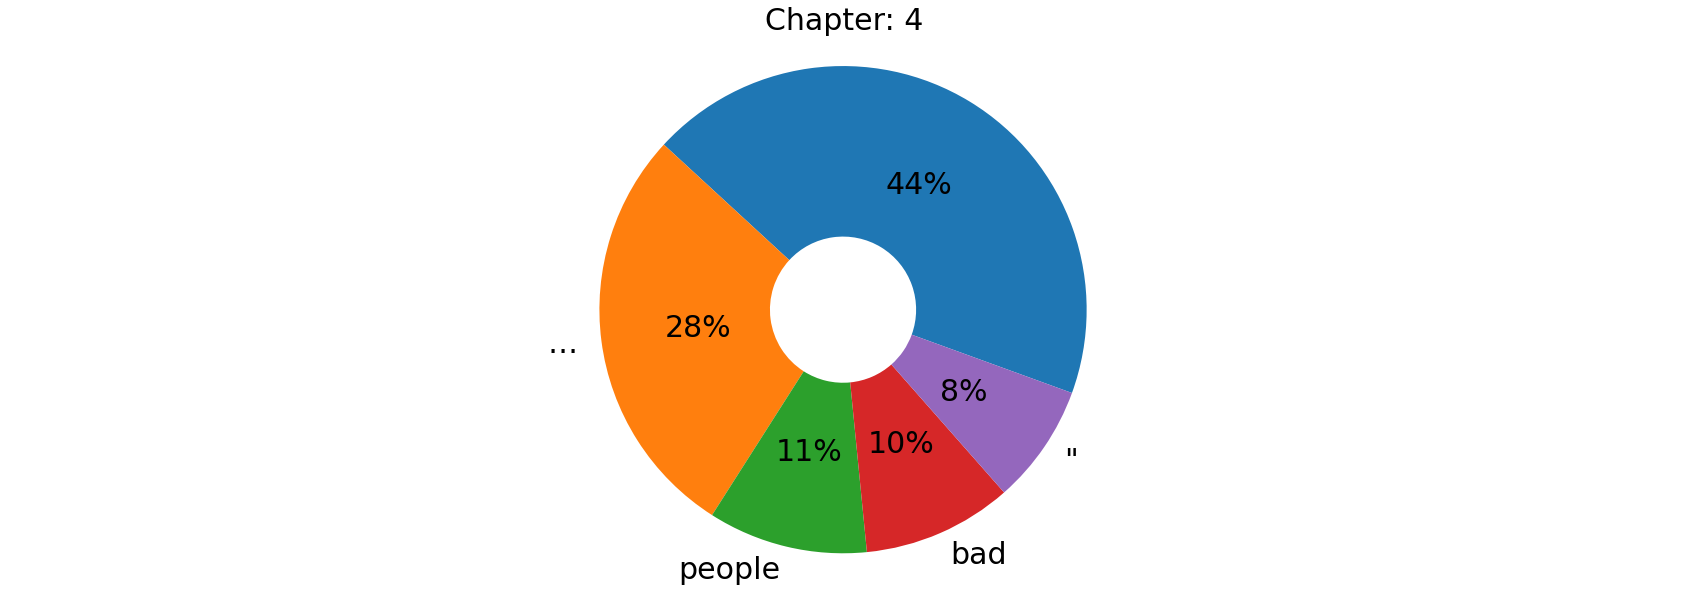

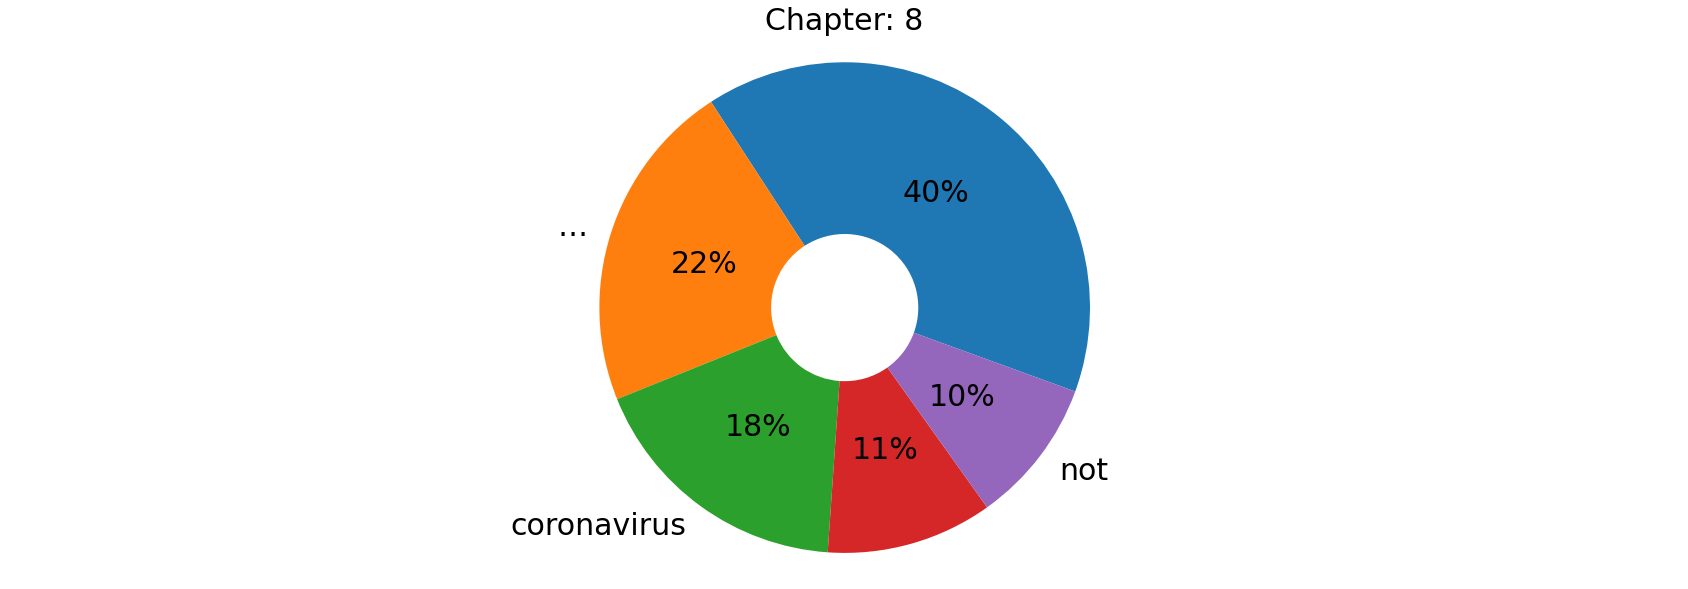

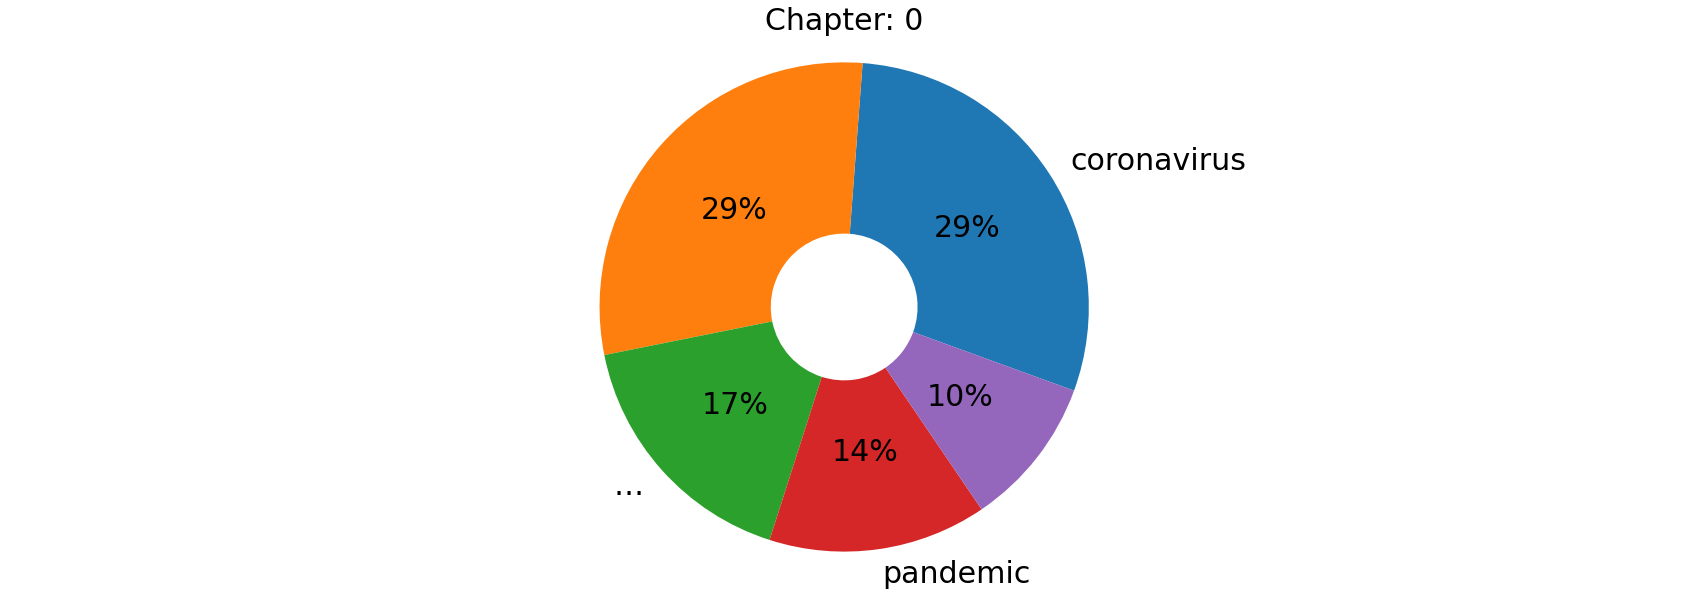

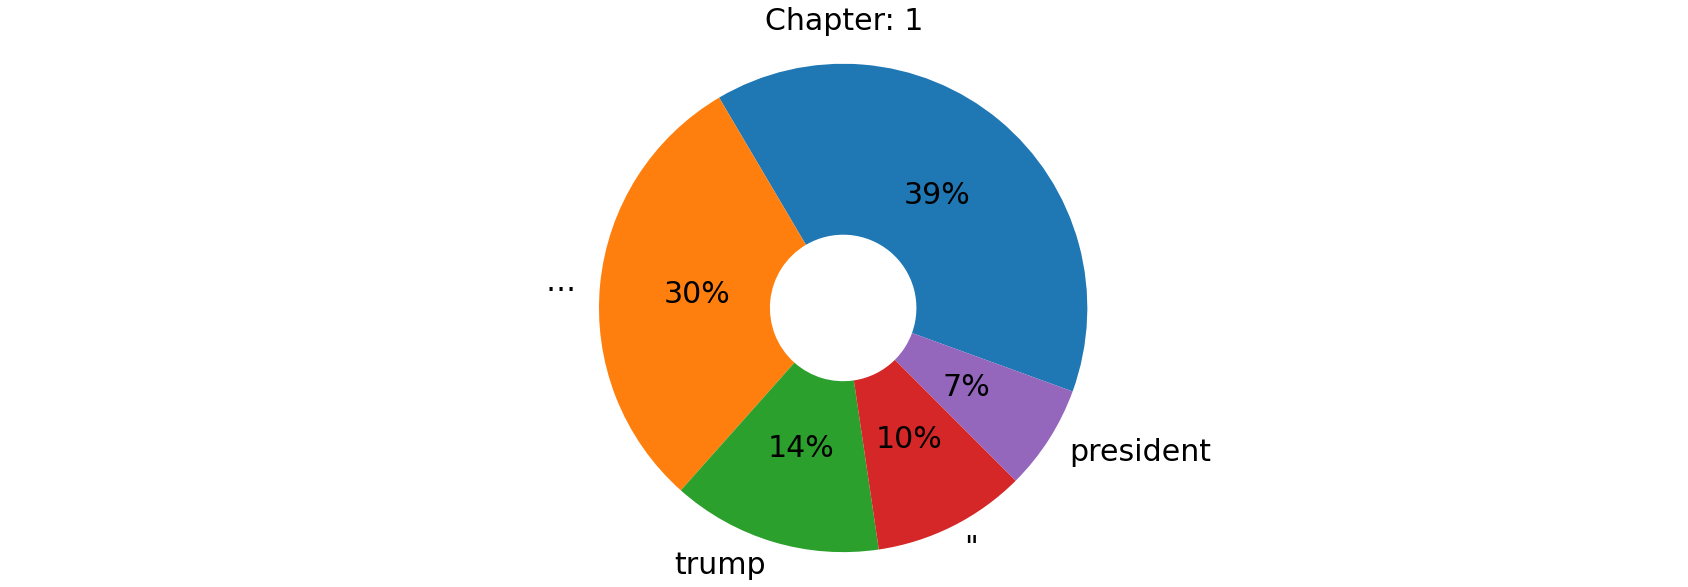

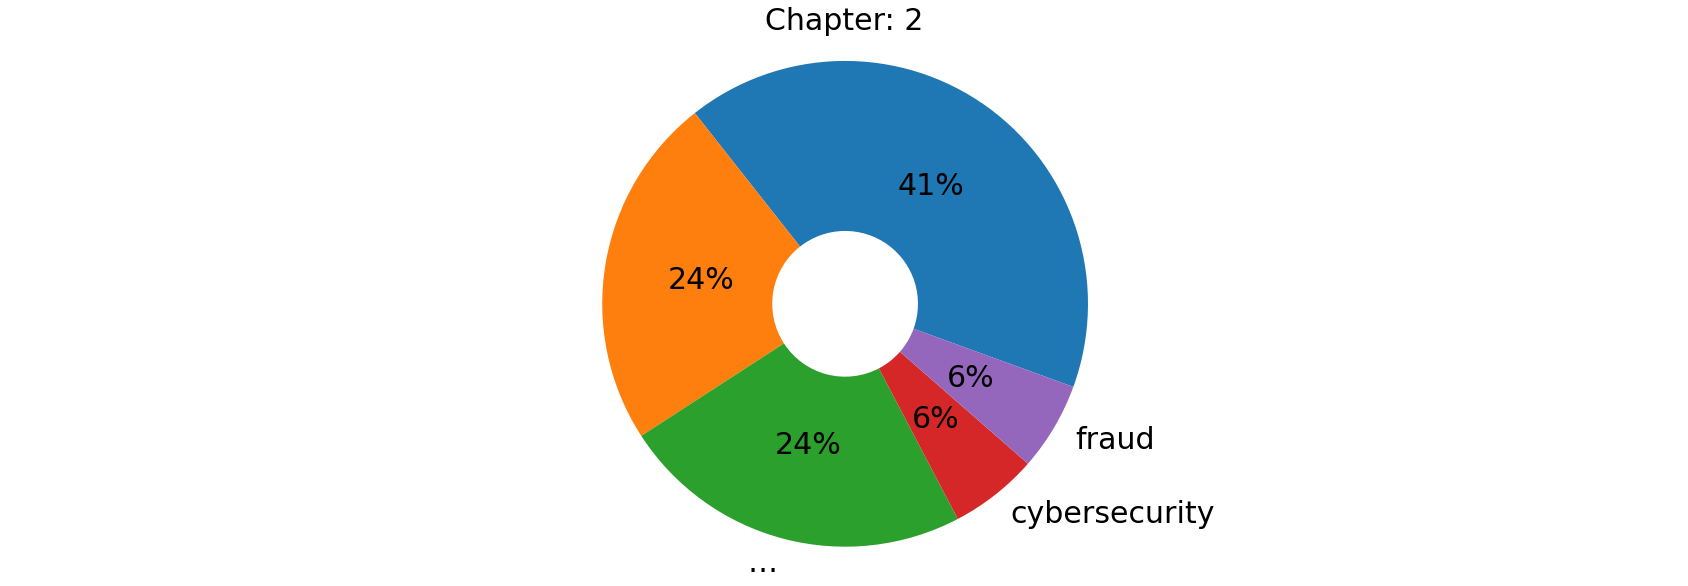

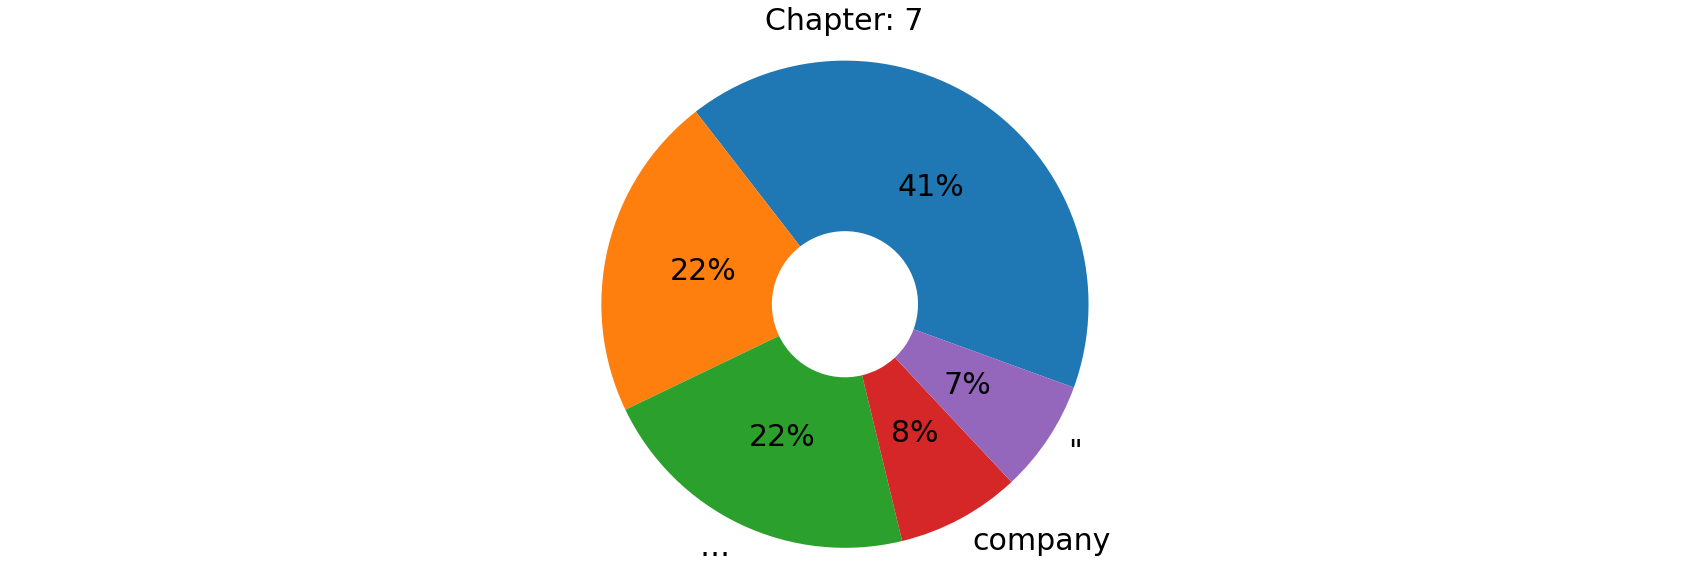

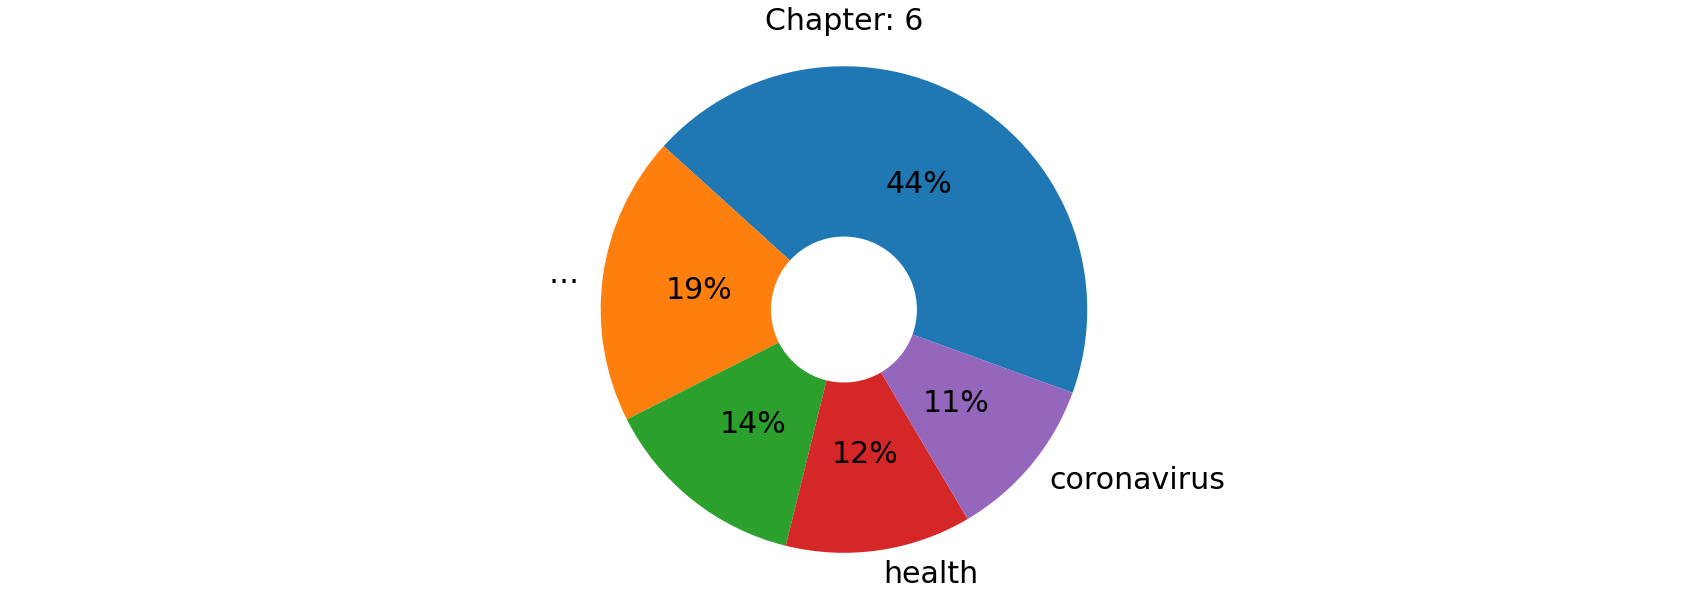

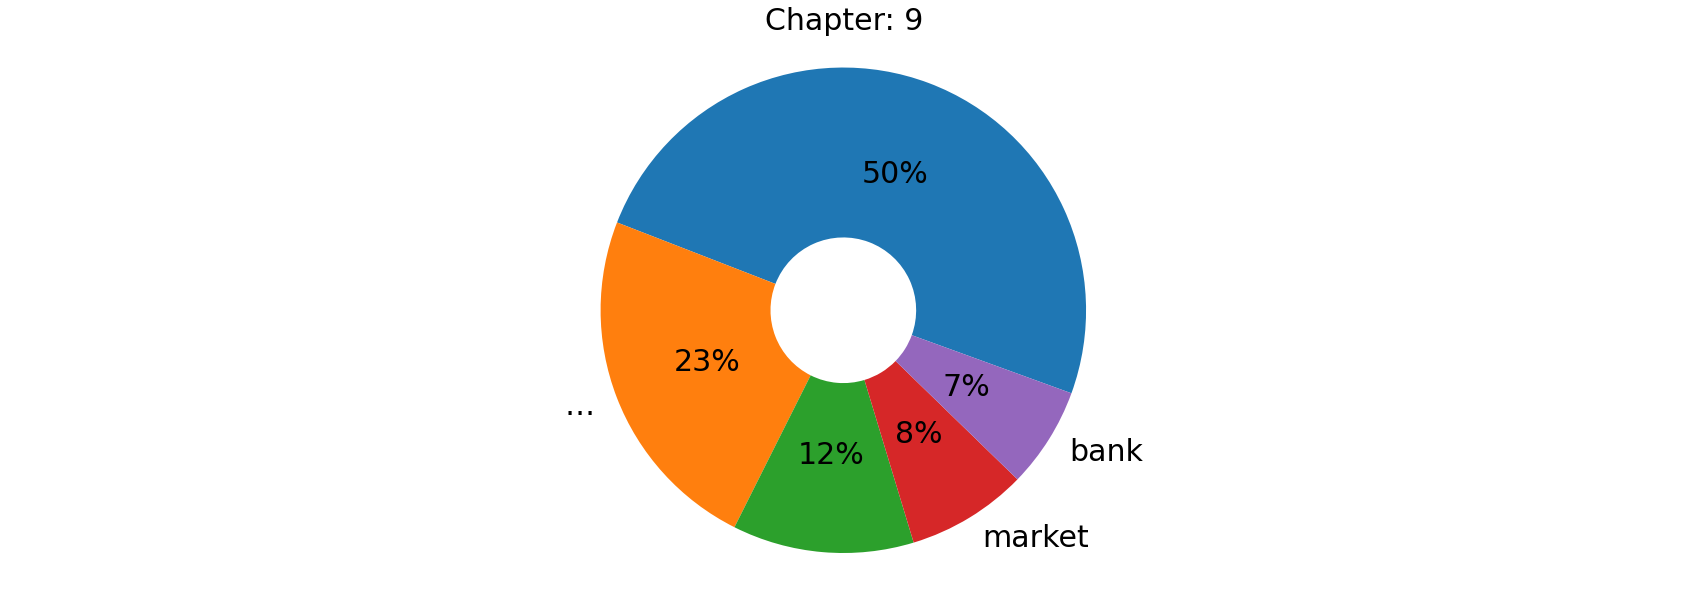

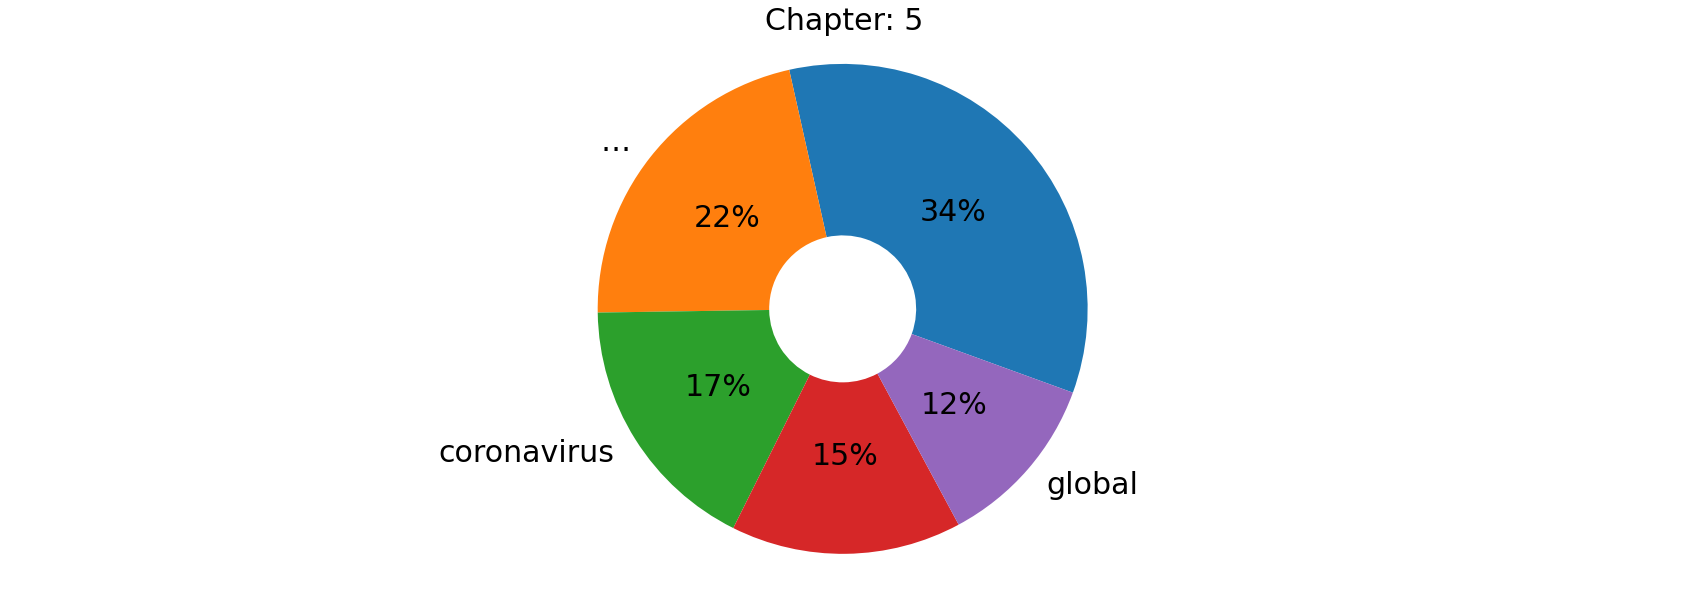

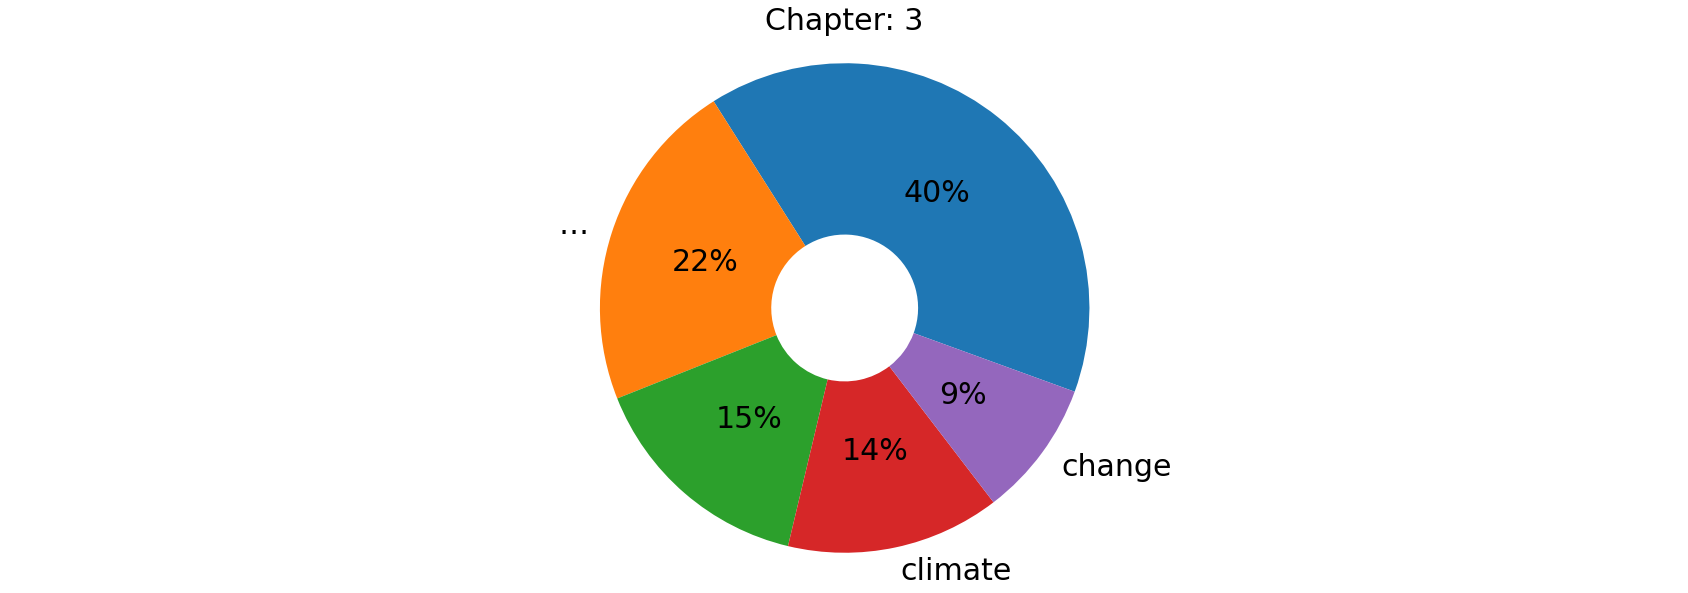

In [ ]:
vocab.most_common_words_per_cluster(data['cluster'].unique(),5)

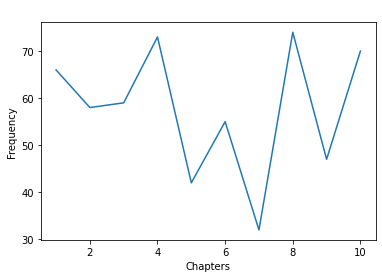

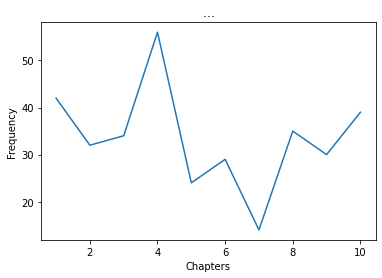

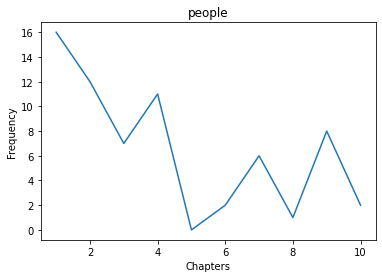

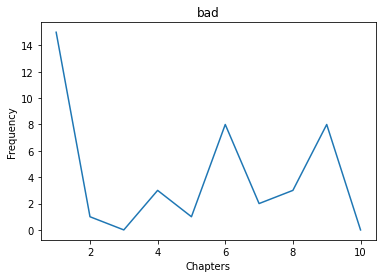

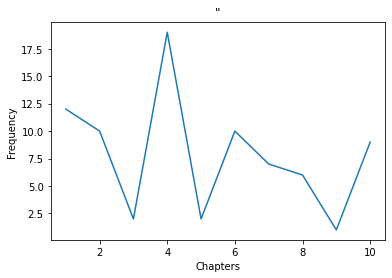

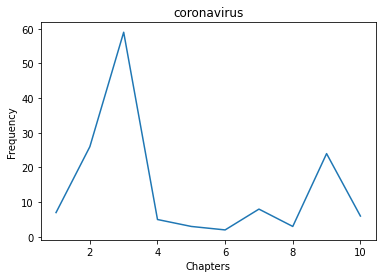

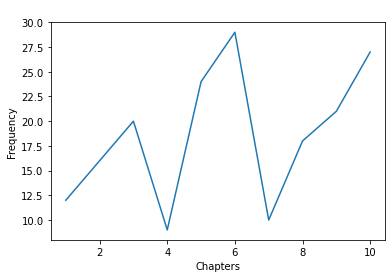

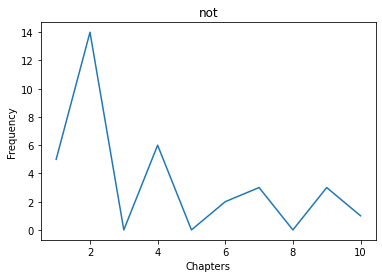

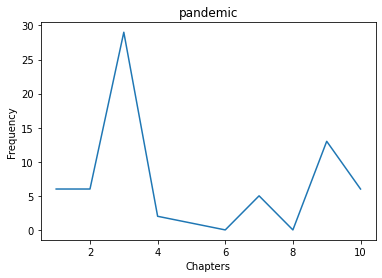

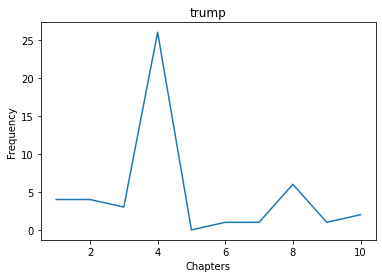

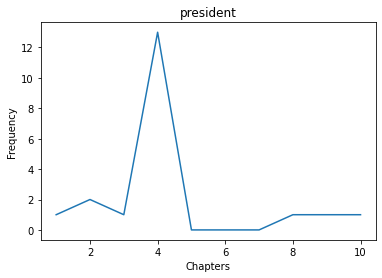

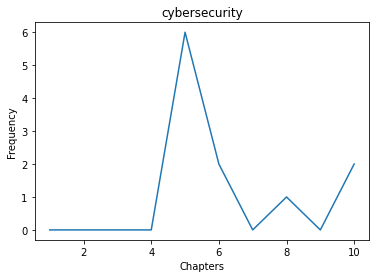

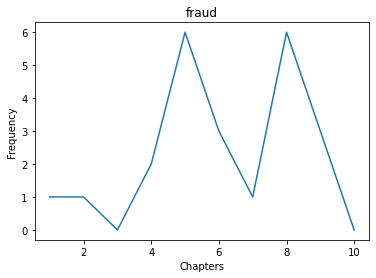

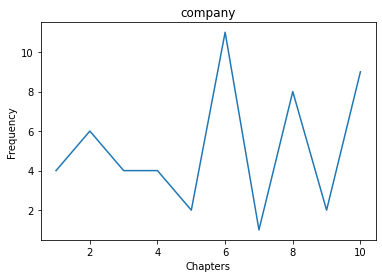

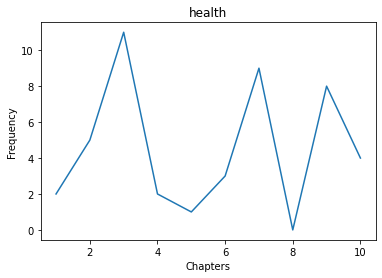

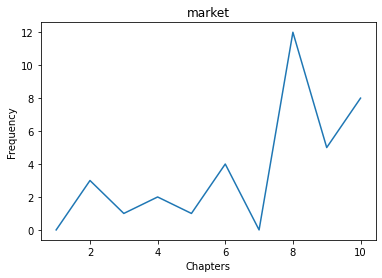

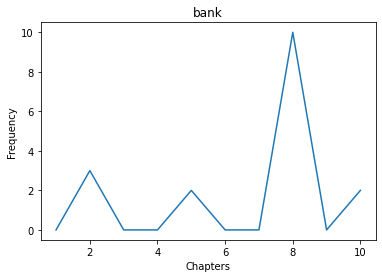

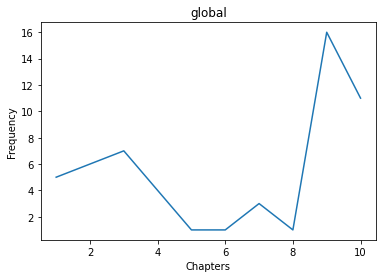

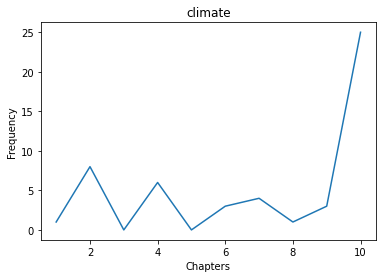

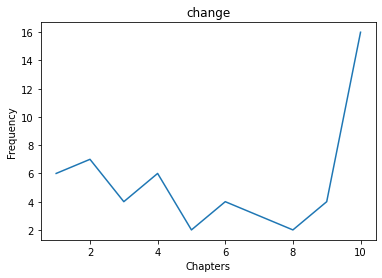

In [ ]:
vocab.more_frequent_words(data['cluster'].unique(),5)
vocab.more_frequent_words_cluster_series_graph()